In [123]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [124]:
# Processing configuration
class Location:
    """Specify the locations of inputs and outputs"""

    # Get the path of the directory containing the script file
    script_dir = os.path.dirname(os.path.abspath(sys.path[0]))

    # Navigate up to the top-level directory
    src_level_dir = os.path.dirname(script_dir)

    top_level_dir = os.path.dirname(src_level_dir)

    # Define the relative path to the data directory
    data_dir = os.path.join(top_level_dir, "AutomatingAnalysisModelsAndMisprediction\\data")

    data_raw: str = f"{data_dir}\\raw\\customer_churn.csv"
    data_csv_process: str = f"{data_dir}\\processed\\customer_churn.csv"
    data_process: str = f"{data_dir}\\processed\\customer_churn.pkl"
    
    
class ProcessConfig:
    """Specify the parameters of the `process` flow"""

    label: str = "Churn"
    test_size: float = 0.2

In [125]:
# Processing functions
def getProcessedData(file_path: str):
    # read python dict back from the file
    with open(file_path, 'rb') as f:
        split_dict = pickle.load(f)

    X_train = split_dict["X_train"]
    X_test = split_dict["X_test"]
    y_train = split_dict["y_train"]
    y_test = split_dict["y_test"]
    return X_train, X_test, y_train, y_test

def getCSVData(url: str):
    data = pd.read_csv(url)
    return data


In [126]:
# Get csv processed data
dataset = getCSVData(Location.data_csv_process)
len(dataset.columns)

41

In [127]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.data_process)


In [128]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)
sc.mean_

array([4.31355932e-01, 1.34140436e-01, 3.75544794e-01, 2.13559322e-01,
       2.75952785e+01, 8.95278450e-01, 5.99636804e-01, 6.79727120e+01,
       2.04012313e+03, 4.18280872e-01, 8.40193705e-02, 3.86440678e-01,
       2.94430993e-01, 5.13922518e-01, 1.61743341e-01, 5.53510896e-01,
       1.61743341e-01, 2.04842615e-01, 4.63075061e-01, 1.61743341e-01,
       2.72518160e-01, 4.66101695e-01, 1.61743341e-01, 2.75665860e-01,
       5.45520581e-01, 1.61743341e-01, 2.11985472e-01, 3.91525424e-01,
       1.61743341e-01, 3.55932203e-01, 3.85472155e-01, 1.61743341e-01,
       3.61138015e-01, 6.39709443e-01, 1.52905569e-01, 1.63438257e-01,
       1.54358354e-01, 1.52663438e-01, 3.54721550e-01, 1.76755448e-01])

In [129]:
sc.scale_

array([4.95265577e-01, 3.40803139e-01, 4.84263257e-01, 4.09819153e-01,
       2.40148008e+01, 3.06194296e-01, 4.89971945e-01, 2.86991180e+01,
       2.18862800e+03, 4.93276782e-01, 2.77416863e-01, 4.86933548e-01,
       4.55786554e-01, 4.99806126e-01, 3.68215199e-01, 4.97128338e-01,
       3.68215199e-01, 4.03586568e-01, 4.98634685e-01, 3.68215199e-01,
       4.45254997e-01, 4.98849581e-01, 3.68215199e-01, 4.46849184e-01,
       4.97923565e-01, 3.68215199e-01, 4.08714609e-01, 4.88091453e-01,
       3.68215199e-01, 4.78794810e-01, 4.86706660e-01, 3.68215199e-01,
       4.80330458e-01, 4.80084650e-01, 3.59896452e-01, 3.69765051e-01,
       3.61291921e-01, 3.59662777e-01, 4.78428858e-01, 3.81461610e-01])

In [130]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)

In [131]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,9 hours 33 mins
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Administrator_71jcrd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.247 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [132]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [134]:
train.columns = list(dataset.columns)
# train[ProcessConfig.label] = train[ProcessConfig.label].asfactor()

In [135]:
# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]

In [136]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
22:35:08.189: AutoML: XGBoost is not available; skipping it.
22:35:08.219: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
22:35:10.862: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████
22:35:32.744: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
22:35:48.978: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categor

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [137]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                                       mse      rmse       mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_2_20230226_223508  0.0994586  0.315371  0.209644  0.222678                 0.0994586
StackedEnsemble_AllModels_1_AutoML_2_20230226_223508     0.0995224  0.315472  0.209508  0.222684                 0.0995224
GBM_3_AutoML_2_20230226_223508                           0.103721   0.322057  0.216855  0.226993                 0.103721
GBM_5_AutoML_2_20230226_223508                           0.10435    0.323032  0.221928  0.227254                 0.10435
GBM_2_AutoML_2_20230226_223508                           0.104627   0.323461  0.220299  0.227841                 0.104627
XRT_1_AutoML_2_20230226_223508                           0.104955   0.323967  0.208112  0.228721                 0.104955
DRF_1_AutoML_2_20230226_223508                           0.105204   0.324352  0.207715  0.228916                 0.105204
GBM_4_AutoML_2_2023022

In [138]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [139]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,5))
# sns.scatterplot(Y_pred, y[ProcessConfig.label] ,ax=ax)
# sns.lineplot(Y_pred,Y_pred,ax=ax,color='black')
# ax.set_xlabel(ProcessConfig.label)

In [140]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [   1    9   15   17   20   21   27   35   55   60   63   67   89  107
  113  132  136  138  141  142  145  157  158  161  163  164  172  178
  188  192  193  201  205  218  225  232  235  249  258  260  267  271
  278  279  281  282  293  308  315  317  329  337  341  342  346  350
  358  369  375  381  399  403  406  412  414  419  421  422  441  446
  465  478  483  488  502  516  520  527  556  558  566  574  580  583
  586  597  601  602  607  623  639  648  655  656  663  664  672  673
  686  687  690  693  696  697  701  703  728  731  733  747  750  760
  762  777  783  787  789  791  805  847  852  859  863  880  892  893
  894  895  906  907  908  916  924  932  935  938  958  996  999 1002
 1014 1016 1037 1040 1042 1049 1052 1053 1060 1071 1073 1077 1080 1081
 1092 1105 1108 1115 1126 1128 1138 1139 1173 1178 1183 1184 1187 1198
 1206 1219 1222 1228 1231 1242 1245 1247 1263 1278 1297 1310 1320 1326
 1330 1338 1343 1369 1373 13

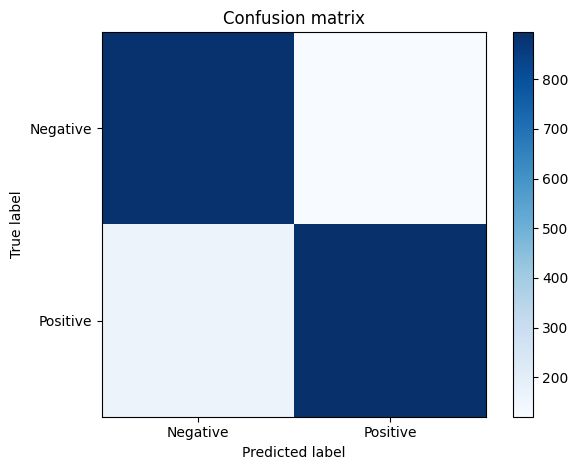

In [141]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

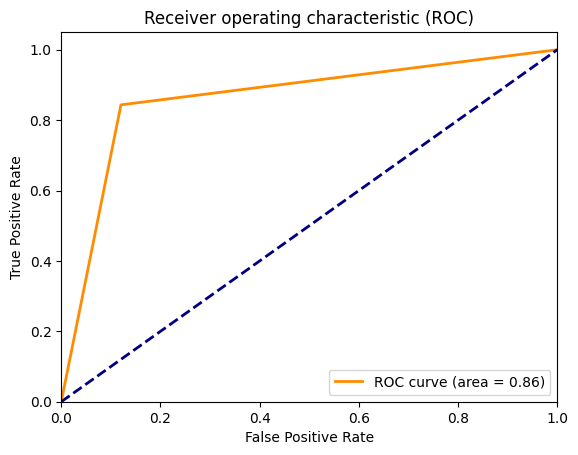

In [142]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()